In [ ]:
pip install contractions

In [ ]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, Dense, Dropout, Layer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Reshape
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from contractions import fix
import nltk

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.layers import GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from keras.models import Sequential
from keras.layers import Embedding, Dropout, Conv1D, MaxPooling1D, LSTM, Dense
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, hamming_loss
import numpy as np

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load dataset
data = pd.read_csv('/content/drive/MyDrive/A/A_forSkripsiii/train.csv')

In [ ]:
data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [ ]:
# Preprocessing
def preprocess_text(text):
    text = text.lower()  # Convert all characters to lowercase
    text = re.sub(r'http\S+|www\S+', 'url', text)  # Replace hyperlinks with "url"
    text = re.sub(r'@\w+', 'username', text)  # Replace usernames with "username"
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', 'number', text)  # Replace numbers with "number"
    text = fix(text)  # Normalize contractions using the 'contractions' library
    text = ' '.join(word_tokenize(text))  # Tokenize text
    return text

# Apply preprocessing
data['comment_text'] = data['comment_text'].apply(preprocess_text)

In [ ]:
text_column = 'comment_text'  # Replace with the correct column name for text

In [ ]:
# Preprocess text data
max_words = 20000
max_len = 200

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(data[text_column])

import pickle

# Save tokenizer to file
with open('/content/drive/MyDrive/A/A_forSkripsiii/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


In [ ]:

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(data[text_column])
word_index = tokenizer.word_index

In [ ]:

# Pad sequences
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

In [ ]:
# Prepare the labels (assume labels are binary for multilabel classification)
labels = data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

In [ ]:
import pandas as pd
word_index0 = tokenizer.word_index

In [ ]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.3, random_state=42)

# Define the CNN + LSTM model
embedding_dim = 256
batch_size = 64

epochs = 10
train_losses = []
val_losses = []
accuracies = []
log_losses = []  # store log loss for each epoch
hamming_losses = []  # store hamming loss for each epoch

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define your model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    Dropout(0.2),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=4),
    LSTM(100, return_sequences=False),
    Dense(6, activation='sigmoid')
])

# Compile the model
model.compile(
    loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy']
)

# Build the model
model.build((batch_size, max_len))
print(model.summary())

# Setup checkpoint callback to save every epoch
checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNN10/model_epoch_{epoch:02d}.h5',
    save_freq='epoch',
    save_weights_only=False,
    save_best_only=False,
    verbose=1
)

# Train the model with checkpoint
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=[checkpoint]
)

# Evaluate
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation loss: {loss}')
print(f'Validation accuracy: {accuracy}')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (64, 200, 256)         │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (64, 200, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (64, 196, 64)          │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (64, 49, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (64, 100)              │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, 6)                │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,268,590 (20.10 MB)

 Trainable params: 5,268,590 (20.10 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9593 - loss: 0.1139
Epoch 1: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNN10/model_epoch_01.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.9593 - loss: 0.1139 - val_accuracy: 0.9940 - val_loss: 0.0502
Epoch 2/10
1742/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9942 - loss: 0.0455
Epoch 2: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNN10/model_epoch_02.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.9942 - loss: 0.0455 - val_accuracy: 0.9940 - val_loss: 0.0494
Epoch 3/10
1742/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9814 - loss: 0.0392
Epoch 3: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNN10/model_epoch_03.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.9814 - loss: 0.0392 - val_accuracy: 0.9940 - val_loss: 0.0528
Epoch 4/10
1744/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9821 - loss: 0.0332
Epoch 4: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNN10/model_epoch_04.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.9820 - loss: 0.0332 - val_accuracy: 0.9604 - val_loss: 0.0551
Epoch 5/10
1742/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9385 - loss: 0.0289
Epoch 5: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNN10/model_epoch_05.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.9385 - loss: 0.0289 - val_accuracy: 0.9627 - val_loss: 0.0567
Epoch 6/10
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9211 - loss: 0.0256
Epoch 6: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNN10/model_epoch_06.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.9211 - loss: 0.0256 - val_accuracy: 0.9197 - val_loss: 0.0644
Epoch 7/10
1742/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7943 - loss: 0.0231
Epoch 7: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNN10/model_epoch_07.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.7940 - loss: 0.0231 - val_accuracy: 0.7768 - val_loss: 0.0670
Epoch 8/10
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6884 - loss: 0.0213
Epoch 8: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNN10/model_epoch_08.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.6884 - loss: 0.0213 - val_accuracy: 0.7282 - val_loss: 0.0671
Epoch 9/10
1743/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6299 - loss: 0.0180
Epoch 9: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNN10/model_epoch_09.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.6299 - loss: 0.0180 - val_accuracy: 0.5693 - val_loss: 0.0795
Epoch 10/10
1744/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6204 - loss: 0.0165
Epoch 10: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNN10/model_epoch_10.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.6203 - loss: 0.0165 - val_accuracy: 0.2861 - val_loss: 0.0771
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.2853 - loss: 0.0754
Validation loss: 0.077111154794693
Validation accuracy: 0.2860753536224365


# EVALUATION

In [ ]:
from keras.models import load_model
from sklearn.metrics import log_loss, hamming_loss
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from google.colab import drive
import pandas as pd
import numpy as np
import os
import re
import pickle
import nltk
from sklearn.model_selection import train_test_split
from contractions import fix
from nltk.tokenize import word_tokenize

# Download tokenizer resources
nltk.download('punkt')

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
model_dir = '/content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNN10'
data_path = '/content/drive/MyDrive/A/A_forSkripsiii/train.csv'
tokenizer_path = '/content/drive/MyDrive/A/A_forSkripsiii/tokenizer.pkl'
os.makedirs(model_dir, exist_ok=True)

# Load dataset
data = pd.read_csv(data_path)

# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', 'url', text)
    text = re.sub(r'@\w+', 'username', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\d+', 'number', text)
    text = fix(text)
    text = ' '.join(word_tokenize(text))
    return text

# Apply preprocessing
text_column = 'comment_text'
data[text_column] = data[text_column].astype(str).apply(preprocess_text)

# Define labels
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
labels = data[label_columns].values

# Tokenizer settings
max_words = 20000
max_len = 200

# Fit tokenizer
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(data[text_column])

# tokenizer
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)

# Convert all text to padded sequences
sequences = tokenizer.texts_to_sequences(data[text_column])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.3, random_state=42)

# Initialize results list
results = []

print("Preprocessing and tokenizer saving complete.")


In [ ]:
# Loop through model files and evaluate
for model_file in os.listdir(model_dir):
    if model_file.endswith(".h5"):
        model_path = os.path.join(model_dir, model_file)
        print(f"Evaluating model: {model_file}")

        # Load model
        model = load_model(model_path)

        # Predict
        y_pred_prob = model.predict(X_val, verbose=0)

        # Evaluate
        loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
        hamming = hamming_loss(np.round(y_pred_prob), y_val)
        logloss = log_loss(y_val, y_pred_prob)

        # Store metrics
        results.append({
            'Model': model_file,
            'Accuracy': accuracy,
            'Log Loss': logloss,
            'Hamming Loss': hamming
        })

# Results dataframe
results_df = pd.DataFrame(results)
print(results_df)


Evaluating model: model_epoch_01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_epoch_02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_epoch_03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_epoch_04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_epoch_05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_epoch_06.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_epoch_07.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_epoch_08.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_epoch_09.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_epoch_10.h5


               Model  Accuracy  Log Loss  Hamming Loss
0  model_epoch_01.h5  0.994047  0.194656      0.018334
1  model_epoch_02.h5  0.994047  0.200783      0.017881
2  model_epoch_03.h5  0.994047  0.220945      0.017958
3  model_epoch_04.h5  0.960394  0.226294      0.018226
4  model_epoch_05.h5  0.962734  0.221308      0.019176
5  model_epoch_06.h5  0.919661  0.293772      0.018261
6  model_epoch_07.h5  0.776759  0.301476      0.018891
7  model_epoch_08.h5  0.728150  0.256462      0.020649
8  model_epoch_09.h5  0.569289  0.378759      0.019026
9  model_epoch_10.h5  0.286075  0.308965      0.020189


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


In [ ]:
results_df

,Model,Accuracy,Log Loss,Hamming Loss
0,model_epoch_01.h5,0.994047,0.194656,0.018334
1,model_epoch_02.h5,0.994047,0.200783,0.017881
2,model_epoch_03.h5,0.994047,0.220945,0.017958
3,model_epoch_04.h5,0.960394,0.226294,0.018226
4,model_epoch_05.h5,0.962734,0.221308,0.019176
5,model_epoch_06.h5,0.919661,0.293772,0.018261
6,model_epoch_07.h5,0.776759,0.301476,0.018891
7,model_epoch_08.h5,0.728150,0.256462,0.020649
8,model_epoch_09.h5,0.569289,0.378759,0.019026
9,model_epoch_10.h5,0.286075,0.308965,0.020189


In [ ]:
import re

# Function to extract model info
def extract_model_info(name):
    match = re.search(r"model_epoch_(\d+)", name)  # Corrected regex
    if match:
        return int(match.group(1))
    return None

# Apply extraction
results_df['Epoch'] = results_df['Model'].apply(extract_model_info)

# Sort by Epoch
results_df_sorted = results_df.sort_values(by=['Epoch']).reset_index(drop=True)

# Display sorted DataFrame
print(results_df_sorted)


               Model  Accuracy  Log Loss  Hamming Loss  Epoch
0  model_epoch_01.h5  0.994047  0.194656      0.018334      1
1  model_epoch_02.h5  0.994047  0.200783      0.017881      2
2  model_epoch_03.h5  0.994047  0.220945      0.017958      3
3  model_epoch_04.h5  0.960394  0.226294      0.018226      4
4  model_epoch_05.h5  0.962734  0.221308      0.019176      5
5  model_epoch_06.h5  0.919661  0.293772      0.018261      6
6  model_epoch_07.h5  0.776759  0.301476      0.018891      7
7  model_epoch_08.h5  0.728150  0.256462      0.020649      8
8  model_epoch_09.h5  0.569289  0.378759      0.019026      9
9  model_epoch_10.h5  0.286075  0.308965      0.020189     10


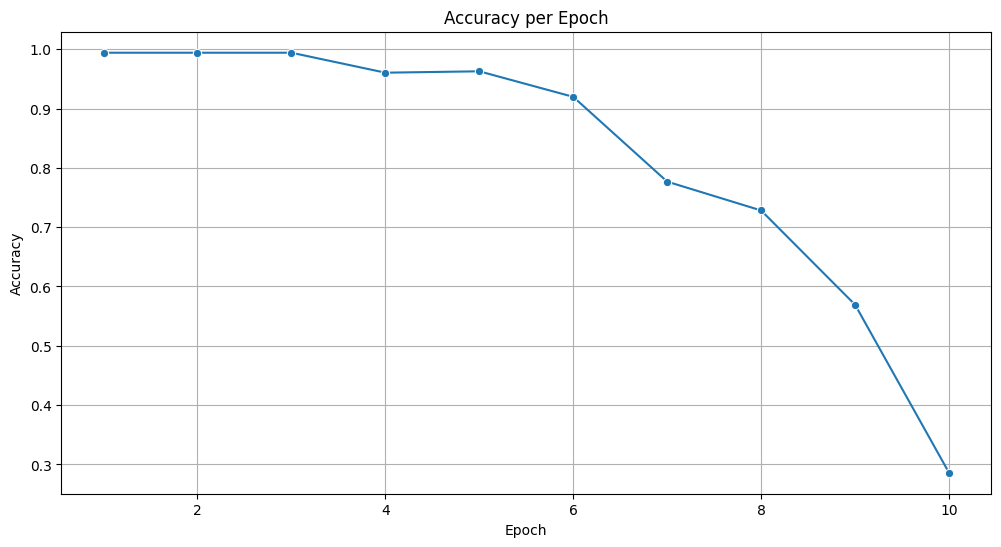

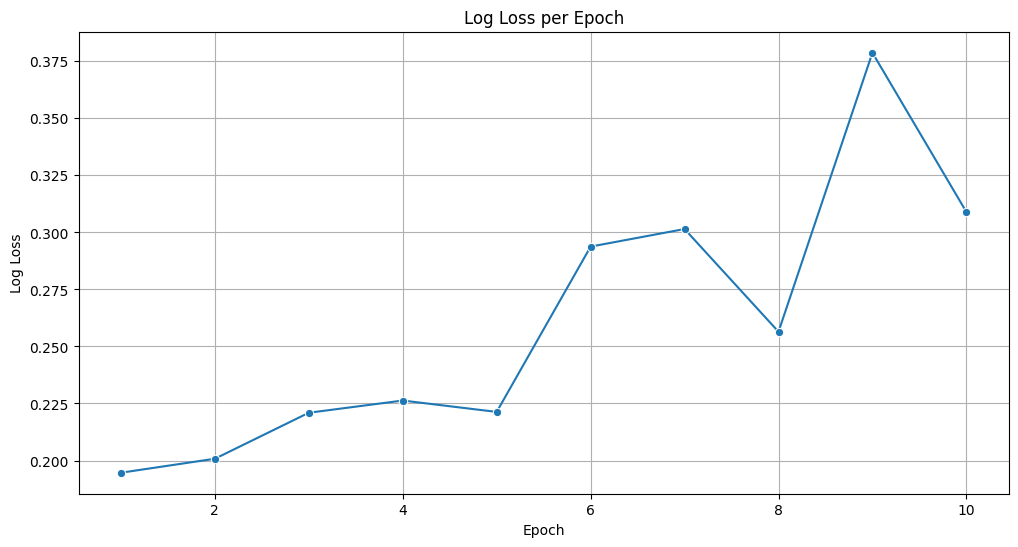

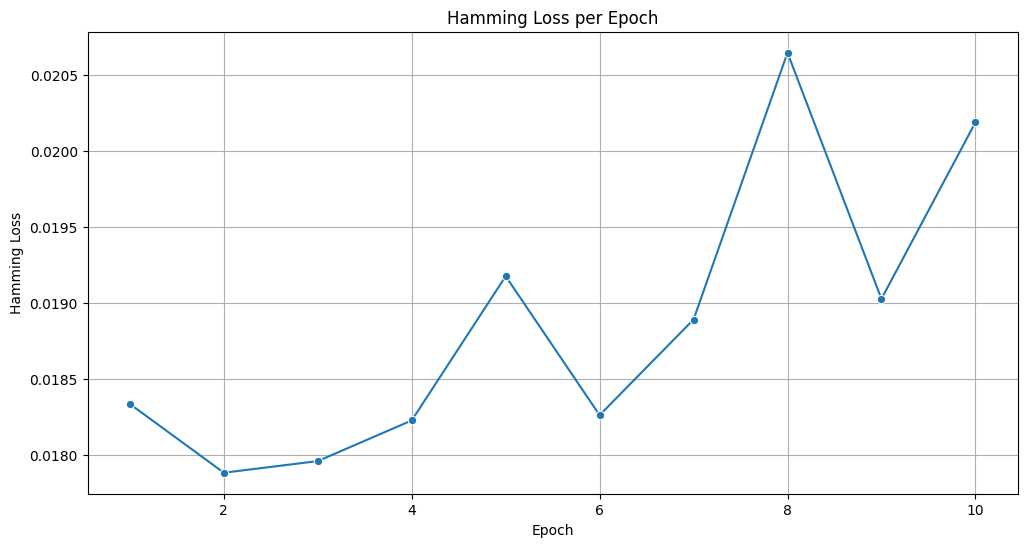

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot Accuracy per Epoch
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='Epoch', y='Accuracy', marker='o')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Plot Log Loss per Epoch
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='Epoch', y='Log Loss', marker='o')
plt.title('Log Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.grid(True)
plt.show()

# Plot Hamming Loss per Epoch
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='Epoch', y='Hamming Loss', marker='o')
plt.title('Hamming Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Hamming Loss')
plt.grid(True)
plt.show()
